# Adaptive preprocessing layers

In [1]:
%cd ..

/data/mas322/amex-project


In [7]:
import yaml
import os
import importlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import importlib.util
import sys
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from src.lib import experimentation
from src.models.adaptive_grunet import AdaptiveGRUNet
from src.models.basic_grunet import GRUNetBasic
from src.experiments.static_preprocessing_methods.standard_scaling import StandardScalerTimeSeries
from src.experiments.static_preprocessing_methods.min_max_scaling import MinMaxTimeSeries

def undo_min_max_corrupt_func(X, y):
    """
    X of shape (num_examples, series_length, num_features)
    In this undo, we assume scale same for each feature, over temporal scale
    """
    # to ensure we get the same mins and scales every time
    np.random.seed(42)
    # randomize both the starting point and the feature scales
    mins = np.random.uniform(-1E4, 1E4, size=X.shape[2])[np.newaxis, None]
    # don't set the smallest scale too tiny, otherwise can lose information due to float 32 bit
    scales = 10 ** np.random.uniform(-1, 5, size=X.shape[2])[np.newaxis, None]

    X_corrupt = X * scales + mins
    return X_corrupt, y

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

loss_fn = F.binary_cross_entropy

def plot_histories(history_list, hist_names):
    assert len(history_list) == len(hist_names)
    
    fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
    
    cols = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:cyan', 'tab:purple']
    
    for h, lab, c in zip(history_list, hist_names, cols):
        try:
            _ = float(h['val_loss'][0])
        except TypeError:
            # use the first cross-validation if passed CV history object
            h = {
                'val_loss' : h['val_loss'][0],
                'train_loss' : h['train_loss'][0],
                'val_amex_metric' : h['val_amex_metric'][0],
                'train_amex_metric' : h['train_amex_metric'][0],
            }
        # loss
        axs[0].plot(h['val_loss'], label=f"{lab} (val)", color=c)
        axs[0].plot(len(h['val_loss']) - 1, h['val_loss'][-1], color=c, marker='o', markersize=5)
        axs[0].plot(h['train_loss'], label=f"{lab} (train)", color=c, linestyle='--')
        axs[0].plot(len(h['train_loss']) - 1, h['train_loss'][-1], color=c, marker='o', markersize=5)
        # amex metric
        axs[1].plot(h['val_amex_metric'], label=f"{lab} (val)", color=c)
        axs[1].plot(len(h['val_amex_metric']) - 1, h['val_amex_metric'][-1], color=c, marker='o', markersize=5)
        axs[1].plot(h['train_amex_metric'], label=f"{lab} (train)", color=c, linestyle='--')
        axs[1].plot(len(h['train_amex_metric']) - 1, h['train_amex_metric'][-1], color=c, marker='o', markersize=5)
    axs[0].set_title("Loss")
    axs[0].legend()
    axs[1].set_title("Competition metric")
    axs[1].legend()
    return fig, axs

## Baseline model (standard scaling)

In [9]:
torch.manual_seed(42) ; np.random.seed(42)
baseline_model = GRUNetBasic(188, 128, 2, 4)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stoppper = experimentation.EarlyStopper(patience=5)

# standard scale on the data
train_loader, val_loader = experimentation.load_numpy_data(os.path.join(cfg['dataset_directory'], "derived", "processed-splits"), [0, 1],
                                                           fill_dict, corrupt_func=undo_min_max_corrupt_func, preprocess_obj=StandardScalerTimeSeries(),
                                                           **data_loader_kwargs)

# fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10, verbose=True, early_stopper=None, device_ids=None)
baseline_history = experimentation.fit_model(baseline_model, loss_fn, train_loader, val_loader, optimizer, scheduler=scheduler, early_stopper=early_stoppper,
                                    verbose=False, num_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

In [3]:
baseline_history = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()

## Tuning DAIN

In [4]:
# Usage: dain.DAIN_Layer
spec = importlib.util.spec_from_file_location("dain", os.path.join(cfg['dain_repo'], 'dain.py'))
dain = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = dain
spec.loader.exec_module(dain)

In [5]:
def dain_optimizer_init(model, lr=1e-3):
    return torch.optim.Adam([
        {'params': model.gru.parameters()},
        {'params': model.emb_layers.parameters()},
        {'params': model.feed_forward.parameters()},
        {'params': model.preprocess.mean_layer.parameters(), 'lr': lr * model.preprocess.mean_lr},
        {'params': model.preprocess.scaling_layer.parameters(), 'lr': lr * model.preprocess.scale_lr},
        {'params': model.preprocess.gating_layer.parameters(), 'lr': lr * model.preprocess.gate_lr},
    ], lr=lr)


torch.manual_seed(42) ; np.random.seed(42)
mean_lr, std_lr, scale_lr = 1e-3, 1e-3, 10
dain_model = AdaptiveGRUNet(lambda D, T: dain.DAIN_Layer(input_dim=D, mode='full', mean_lr=mean_lr, scale_lr=std_lr, gate_lr=scale_lr), 188, 128, 2, 4)
optimizer = dain_optimizer_init(dain_model, lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stoppper = experimentation.EarlyStopper(patience=5)

# no preprocessing on the data
train_loader, val_loader = experimentation.load_numpy_data(os.path.join(cfg['dataset_directory'], "derived", "processed-splits"), [0, 1],
                                                           fill_dict, corrupt_func=undo_min_max_corrupt_func, preprocess_obj=None,
                                                           batch_size=1024)

# fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10, verbose=True, early_stopper=None, device_ids=None)
dain_history = experimentation.fit_model(dain_model, loss_fn, train_loader, val_loader, optimizer,
                                    scheduler=scheduler, early_stopper=early_stoppper,
                                    verbose=False, num_epochs=40)

Mode =  full


  0%|          | 0/40 [00:00<?, ?it/s]

/home/mas322/anaconda3/envs/cudf-torch/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


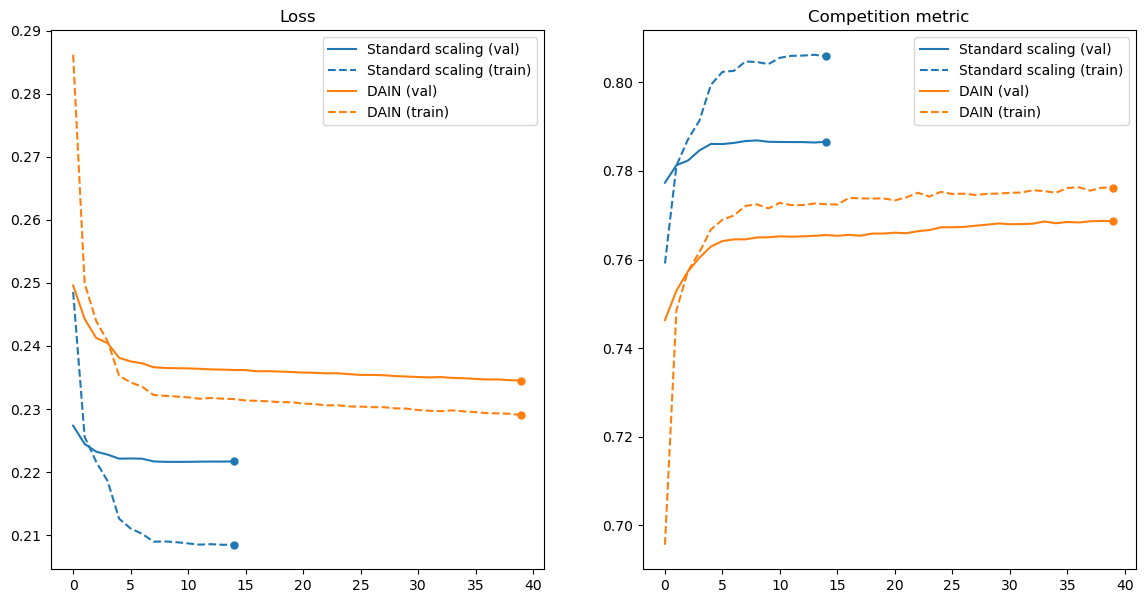

In [6]:
fig, axs = plot_histories([baseline_history, dain_history], ['Standard scaling', 'DAIN'])

In [53]:
for x in train_loader:
    print(x[0].shape)
    break

torch.Size([1024, 13, 188])


## BiN layer

In [9]:
# Usage: tabl.BiN
spec = importlib.util.spec_from_file_location("tabl", os.path.join(cfg['mlproject_repo'], 'mlproject', 'models', 'tabl.py'))
tabl = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tabl
spec.loader.exec_module(tabl)

In [24]:
def bin_optimizer_init(model, lr=1e-3, lambd=0.01):
    return torch.optim.Adam([
        {'params': model.gru.parameters()},
        {'params': model.emb_layers.parameters()},
        {'params': model.feed_forward.parameters()},
        {'params': model.preprocess.parameters(), 'lr': lr * lambd},
    ], lr=lr)

torch.manual_seed(42) ; np.random.seed(42)
bin_model = AdaptiveGRUNet(lambda D, T: tabl.BiN(input_shape=(D, T)), 188, 128, 2, 4)
optimizer = bin_optimizer_init(bin_model, lambd=1e-6)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stoppper = experimentation.EarlyStopper(patience=5)

# no preprocessing on the data
train_loader, val_loader = experimentation.load_numpy_data(os.path.join(cfg['dataset_directory'], "derived", "processed-splits"), [0, 1],
                                                           fill_dict, corrupt_func=undo_min_max_corrupt_func, preprocess_obj=StandardScalerTimeSeries(),
                                                           batch_size=4000)

# fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10, verbose=True, early_stopper=None, device_ids=None)
bin_history = experimentation.fit_model(bin_model, loss_fn, train_loader, val_loader, optimizer,
                                    scheduler=scheduler, early_stopper=early_stoppper,
                                    verbose=False, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
fig, axs = plot_histories([baseline_history, dain_history, bin_history], ['Standard scaling', 'DAIN', 'BiN'])

## Full DAIN 

In [15]:
import src.preprocessing.adaptive_transformations as at
importlib.reload(at)

<module 'src.preprocessing.adaptive_transformations' from '/home/mas322/amex-project/src/preprocessing/adaptive_transformations.py'>

In [26]:
def dain_full_optimizer_init(model, lr=1e-3):
    return torch.optim.Adam([
        {'params': model.gru.parameters()},
        {'params': model.emb_layers.parameters()},
        {'params': model.feed_forward.parameters()},
        {'params': model.preprocess.winsorization_params(), 'lr': lr * 1e-1},
        {'params': model.preprocess.power_transform_params(), 'lr': lr * 1e-6},
        {'params': model.preprocess.scaling_params(), 'lr': lr * 1e-1},
        {'params': model.preprocess.shift_params(), 'lr': lr * 1e-1},
    ], lr=lr)

torch.manual_seed(42) ; np.random.seed(42)
dain_model = AdaptiveGRUNet(lambda D, T: at.FullDAIN_Layer(input_dim=D, time_series_length=T, adaptive_scale=True, adaptive_power_transform=False, adaptive_shift=True, adaptive_winsorization=True), 188, 128, 2, 4)
optimizer = dain_full_optimizer_init(dain_model, lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stoppper = experimentation.EarlyStopper(patience=5)

In [11]:
# no preprocessing on the data
train_loader, val_loader = experimentation.load_numpy_data(os.path.join(cfg['dataset_directory'], "derived", "processed-splits"), [0, 1],
                                                           fill_dict, corrupt_func=undo_min_max_corrupt_func, preprocess_obj=MinMaxTimeSeries(),
                                                           batch_size=1024)

In [27]:
# fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10, verbose=True, early_stopper=None, device_ids=None)
full_dain_history = experimentation.fit_model(dain_model, loss_fn, train_loader, val_loader, optimizer,
                                    scheduler=scheduler, early_stopper=early_stoppper,
                                    verbose=False, num_epochs=10, device_ids=None)

Using device = cuda


  0%|          | 0/10 [00:00<?, ?it/s]

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}>,
        <Axes: title={'center': 'Competition metric'}>], dtype=object))

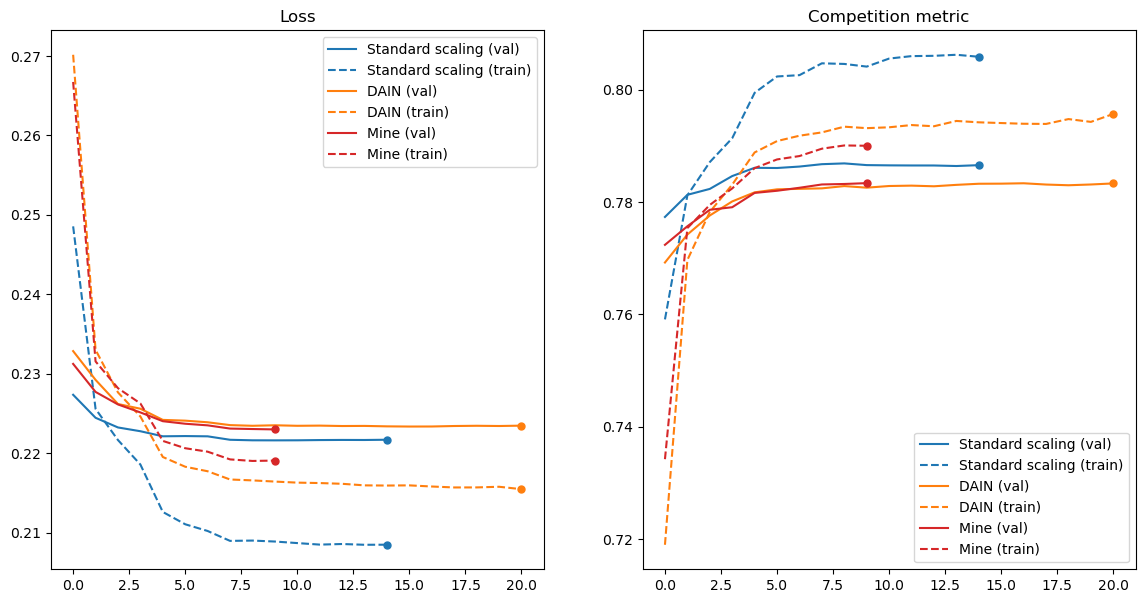

In [28]:
baseline_history = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
dain_history = np.load(os.path.join(cfg['experiment_directory'], 'dain-standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
plot_histories([baseline_history, dain_history, full_dain_history], ['Standard scaling', 'DAIN', 'Mine'])

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}>,
        <Axes: title={'center': 'Competition metric'}>], dtype=object))

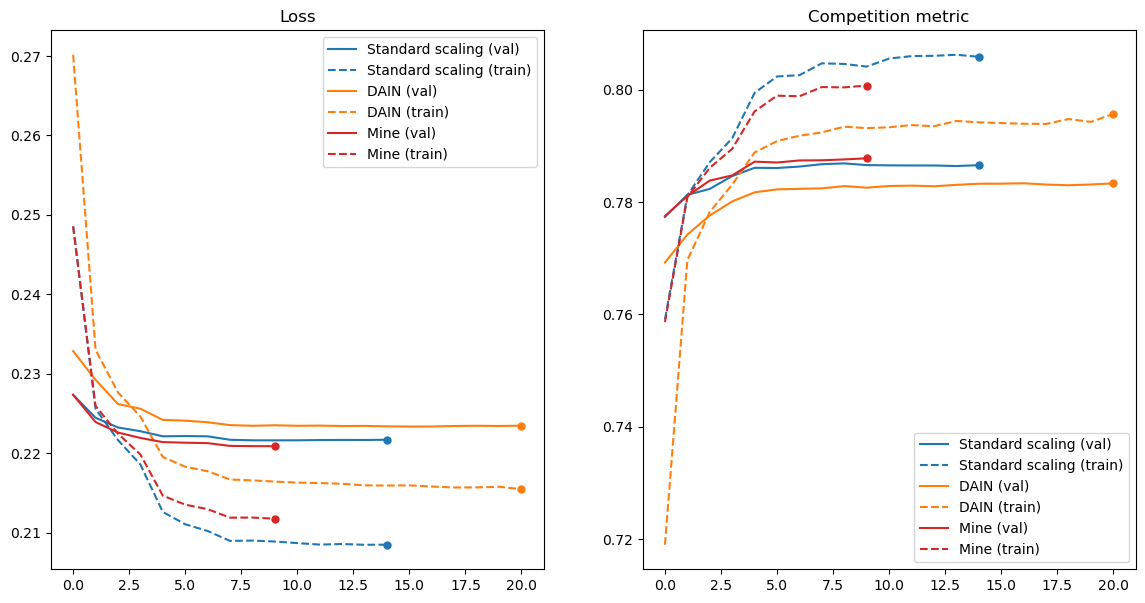

In [146]:
baseline_history = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
dain_history = np.load(os.path.join(cfg['experiment_directory'], 'dain-standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
plot_histories([baseline_history, dain_history, full_dain_history], ['Standard scaling', 'DAIN', 'Mine'])

In [30]:
torch.sigmoid(dain_model.preprocess.skip_scale)

tensor([[[0.4945, 0.5004, 0.4999,  ..., 0.4992, 0.5034, 0.4983],
         [0.4971, 0.5009, 0.4992,  ..., 0.4979, 0.5026, 0.4977],
         [0.4975, 0.5016, 0.5021,  ..., 0.4983, 0.5023, 0.4996],
         ...,
         [0.4995, 0.4953, 0.5002,  ..., 0.4991, 0.5003, 0.5005],
         [0.4996, 0.4997, 0.5003,  ..., 0.5007, 0.5000, 0.5003],
         [0.4964, 0.4991, 0.4989,  ..., 0.5015, 0.4998, 0.4999]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [34]:
dain_model.preprocess.scaling_layer.weight.data

tensor([[ 0.9908, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
        [-0.0018,  0.9983, -0.0017,  ..., -0.0018, -0.0018, -0.0017],
        [-0.0014, -0.0014,  0.9986,  ..., -0.0014, -0.0014, -0.0014],
        ...,
        [ 0.0042,  0.0042,  0.0042,  ...,  1.0042,  0.0042,  0.0042],
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  1.0028,  0.0028],
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  1.0014]],
       device='cuda:0')